In [6]:
import numpy as np
import os
import pathlib
import random
import torch
import pytorch3d.transforms
import torchgeometry
import cv2
from dlclive import DLCLive, Processor

import matplotlib.pyplot as plt
from random import randrange
import random
from IPython.display import clear_output

from torch.utils.data import DataLoader

# potential mass parametrizations
from differentiable_robot_model.rigid_body_params import (
    UnconstrainedScalar,
    PositiveScalar,
    UnconstrainedTensor,
)

# potential inertia matrix parametrizations
from differentiable_robot_model.rigid_body_params import (
    CovParameterized3DInertiaMatrixNet,
    Symm3DInertiaMatrixNet,
    SymmPosDef3DInertiaMatrixNet,
    TriangParam3DInertiaMatrixNet,
)

from differentiable_robot_model.robot_model import (
    DifferentiableRobotModel,
    DifferentiableKUKAiiwa,
)
from differentiable_robot_model.data_utils import (
    generate_sine_motion_forward_dynamics_data,
)
import diff_robot_data

torch.set_printoptions(precision=3, sci_mode=False)

random.seed(0)
np.random.seed(1)
torch.manual_seed(0)


In [7]:
USE_GPU = True
device = torch.device("cpu")
try:
    if USE_GPU and torch.cuda.is_available():
        device = torch.device('cuda')
    elif torch.backends.mps.is_available():
        device = torch.device("mps")
    else:
        device = torch.device('cpu')
except:
    if USE_GPU and torch.cuda.is_available():
        device = torch.device('cuda')
    else:
        device = torch.device('cpu')
device = torch.device('cpu')
device

device(type='cpu')

In [8]:
class NMSELoss(torch.nn.Module):
    def __init__(self, var):
        super(NMSELoss, self).__init__()
        self.var = var

    def forward(self, yp, yt):
        err = (yp - yt) ** 2
        werr = err / self.var
        return werr.mean()

class ConstrainedTensor(torch.nn.Module):
    def __init__(self, dim1, dim2, init_tensor=None, init_std=0.1, min_val=0.0, max_val=1.0):
        super().__init__()
        self._dim1 = dim1
        self._dim2 = dim2
        if init_tensor is None:
            init_tensor = torch.empty(dim1, dim2).normal_(mean=0.0, std=init_std)
        self.param = torch.nn.Parameter(init_tensor)
        self.min_val = min_val
        self.max_val = max_val

    def forward(self):
        param = self.param
        param = torch.clamp(param, min=self.min_val, max=self.max_val)
        return param

urdf_path = os.path.join("a1.urdf")
learnable_robot_model = DifferentiableRobotModel(
    urdf_path, "A1", device=device
)

learnable_robot_model.make_link_param_learnable(
    "FR_hip", "trans", UnconstrainedTensor(dim1 = 1, dim2 = 3)
)
learnable_robot_model.make_link_param_learnable(
        "FR_thigh_shoulder", "trans", UnconstrainedTensor(dim1 = 1, dim2 = 3)
    )
learnable_robot_model.make_link_param_learnable(
        "FR_thigh", "trans", UnconstrainedTensor(dim1 = 1, dim2 = 3)
    )
learnable_robot_model.make_link_param_learnable(
        "FR_calf", "trans", UnconstrainedTensor(dim1 = 1, dim2 = 3)
    )
learnable_robot_model.make_link_param_learnable(
        "FR_foot", "trans", UnconstrainedTensor(dim1 = 1, dim2 = 3)
    )
learnable_robot_model.make_link_param_learnable(
        "FL_hip", "trans", UnconstrainedTensor(dim1 = 1, dim2 = 3)
    )
learnable_robot_model.make_link_param_learnable(
        "FL_thigh_shoulder", "trans", UnconstrainedTensor(dim1 = 1, dim2 = 3)
    )
learnable_robot_model.make_link_param_learnable(
        "FL_thigh", "trans", UnconstrainedTensor(dim1 = 1, dim2 = 3)
    )
learnable_robot_model.make_link_param_learnable(
        "FL_calf", "trans", UnconstrainedTensor(dim1 = 1, dim2 = 3)
    )
learnable_robot_model.make_link_param_learnable(
        "FL_foot", "trans", UnconstrainedTensor(dim1 = 1, dim2 = 3)
    )
learnable_robot_model.make_link_param_learnable(
        "RR_hip", "trans", UnconstrainedTensor(dim1 = 1, dim2 = 3)
    )
learnable_robot_model.make_link_param_learnable(
        "RR_thigh_shoulder", "trans", UnconstrainedTensor(dim1 = 1, dim2 = 3)
    )
learnable_robot_model.make_link_param_learnable(
        "RR_thigh", "trans", UnconstrainedTensor(dim1 = 1, dim2 = 3)
    )
learnable_robot_model.make_link_param_learnable(
        "RR_calf", "trans", UnconstrainedTensor(dim1 = 1, dim2 = 3)
    )
learnable_robot_model.make_link_param_learnable(
        "RR_foot", "trans", UnconstrainedTensor(dim1 = 1, dim2 = 3)
    )
learnable_robot_model.make_link_param_learnable(
        "RL_hip", "trans", UnconstrainedTensor(dim1 = 1, dim2 = 3)
    )
learnable_robot_model.make_link_param_learnable(
        "RL_thigh_shoulder", "trans", UnconstrainedTensor(dim1 = 1, dim2 = 3)
    )
learnable_robot_model.make_link_param_learnable(
        "RL_thigh", "trans", UnconstrainedTensor(dim1 = 1, dim2 = 3)
    )
learnable_robot_model.make_link_param_learnable(
        "RL_calf", "trans", UnconstrainedTensor(dim1 = 1, dim2 = 3)
    )
learnable_robot_model.make_link_param_learnable(
        "RL_foot", "trans", UnconstrainedTensor(dim1 = 1, dim2 = 3)
    )
pass

Unknown tag "hardwareInterface" in /robot[@name='a1']/transmission[@name='FR_hip_tran']/actuator[@name='FR_hip_motor']
Unknown tag "hardwareInterface" in /robot[@name='a1']/transmission[@name='FR_thigh_tran']/actuator[@name='FR_thigh_motor']
Unknown tag "hardwareInterface" in /robot[@name='a1']/transmission[@name='FR_calf_tran']/actuator[@name='FR_calf_motor']
Unknown tag "hardwareInterface" in /robot[@name='a1']/transmission[@name='FL_hip_tran']/actuator[@name='FL_hip_motor']
Unknown tag "hardwareInterface" in /robot[@name='a1']/transmission[@name='FL_thigh_tran']/actuator[@name='FL_thigh_motor']
Unknown tag "hardwareInterface" in /robot[@name='a1']/transmission[@name='FL_calf_tran']/actuator[@name='FL_calf_motor']
Unknown tag "hardwareInterface" in /robot[@name='a1']/transmission[@name='RR_hip_tran']/actuator[@name='RR_hip_motor']
Unknown tag "hardwareInterface" in /robot[@name='a1']/transmission[@name='RR_thigh_tran']/actuator[@name='RR_thigh_motor']
Unknown tag "hardwareInterface" 

In [9]:
learnable_robot_model.print_link_names()

base
trunk
imu_link
FR_hip
FR_thigh_shoulder
FR_thigh
FR_calf
FR_foot
FL_hip
FL_thigh_shoulder
FL_thigh
FL_calf
FL_foot
RR_hip
RR_thigh_shoulder
RR_thigh
RR_calf
RR_foot
RL_hip
RL_thigh_shoulder
RL_thigh
RL_calf
RL_foot


In [12]:
keypoints = """End of Neck
Shoulder
FL_Knee
FL_Ankle
FL_White_TapeTop
FL_White_TapeBot
FR_Knee
FR_Ankle
FL_Red_TapeTop
FL_Red_TapeBot
End of Tail
Hip
BL_Knee
BL_Ankle
BL_Red_TapeTop
BL_Red_TapeBot
BR_Knee
BR_Ankle
BR_Red_TapeTop
BR_Red_TapeBot""".split("\n")

image_robot_mapping = {'FL_Ankle': "FL_foot",
                       'FR_Ankle': "FR_foot",
                       'FL_Knee': "FL_calf",
                       'FR_Knee': "FR_calf",
                       'BL_Ankle': "RR_foot",
                       'BR_Ankle': "RL_foot",
                       'BL_Knee': "RR_calf", 
                       'BR_Knee': "RL_calf", 
                       "Hip": "RR_hip", 
                       "Shoulder":"FL_thigh_shoulder"}
training_keypoints = list(image_robot_mapping.keys())
robot_joints_for_training = [image_robot_mapping[k] for k in training_keypoints]
indices_keypoints_training = [keypoints.index(val) for val in training_keypoints]

base_dir = pathlib.Path.cwd()
img_path = base_dir / "HorseInferenceFiles/img0088.png"
dlc_model_path = base_dir/"HorseInferenceFiles/DLC_HorseProject1_efficientnet-b0_iteration-0_shuffle-1"
image = cv2.imread(str(img_path))
print(f"Image Size: {image.shape}")
dlc_proc = Processor()
dlc_live = DLCLive(model_path=str(dlc_model_path), processor=dlc_proc)
pose = dlc_live.init_inference(image)
# X,Y coords of selected keypoints
training_data = pose[indices_keypoints_training][:,0:2]
training_data

Image Size: (360, 640, 3)


2023-07-31 16:29:59.538435: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-31 16:29:59.592517: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:354] MLIR V1 optimization pass is not enabled


array([[275.79907, 244.88426],
       [243.89044, 255.31282],
       [249.62645, 216.09793],
       [245.29861, 214.37358],
       [340.4294 , 246.94559],
       [393.5513 , 248.9645 ],
       [349.00183, 210.68068],
       [383.40588, 209.36082],
       [374.91888, 144.18417],
       [262.60123, 159.43997]], dtype=float32)

In [13]:
def homogenize_vectors(tensor, padding_size = 1):
  padded_tensor = torch.nn.functional.pad(
      tensor, pad=(0, padding_size), mode='constant', value=1)
  return padded_tensor

def dehomogenize_vector(tensor, padding_size=1):
  cropped_tensor = tensor[..., :-padding_size]
  return cropped_tensor

## Training Loop

Starting Training
Epoch 0: Loss (1260.166748046875)
Epoch 0: Loss (1260.166748046875)
Plotted Image Size: (360, 640, 3)
Plotted Image Size: (360, 640, 3)
Drawing base
Plotted Image Size: (360, 640, 3)
Plotted Image Size: (360, 640, 3)


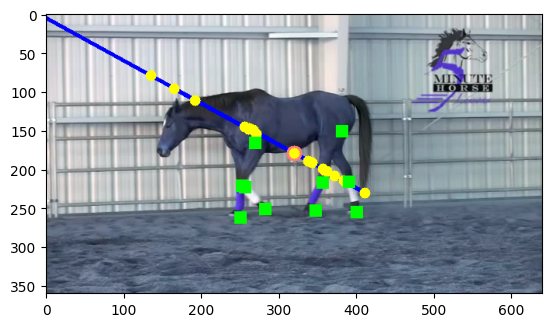

Passed Epoch 0
Passed Epoch 1
Epoch 100: Loss (478.93768310546875)


KeyboardInterrupt: 

In [15]:
#Each entry is a line for the skeleton to be drawn
#Script pulls from the urdf file the links.
"""
import xml.etree.ElementTree as ET
tree = ET.parse("a1.urdf")
root = tree.getroot()
joints = root.finall(".//joint")
lines = [(joint.find("./parent").attrib.get("link"),joint.find("./child").attrib.get("link")) for joint in joints if joint.find("./parent") is not None if joint.find("./child") is not None]
"""
links = [('base', 'trunk'), ('trunk', 'imu_link'), ('trunk', 'FR_hip'), ('FR_hip', 'FR_thigh_shoulder'), ('FR_hip', 'FR_thigh'), ('FR_thigh', 'FR_calf'), ('FR_calf', 'FR_foot'), ('trunk', 'FL_hip'), ('FL_hip', 'FL_thigh_shoulder'), ('FL_hip', 'FL_thigh'), ('FL_thigh', 'FL_calf'), ('FL_calf', 'FL_foot'), ('trunk', 'RR_hip'), ('RR_hip', 'RR_thigh_shoulder'), ('RR_hip', 'RR_thigh'), ('RR_thigh', 'RR_calf'), ('RR_calf', 'RR_foot'), ('trunk', 'RL_hip'), ('RL_hip', 'RL_thigh_shoulder'), ('RL_hip', 'RL_thigh'), ('RL_thigh', 'RL_calf'), ('RL_calf', 'RL_foot')]


init_angles = torch.tensor([0.0 for joint in learnable_robot_model.get_joint_limits()])
joint_angles = init_angles.requires_grad_(True)

constantTensor = lambda constant: torch.tensor(float(constant))
differentiableConstantTensor = lambda constant: torch.tensor(float(constant), requires_grad=True)

fx = differentiableConstantTensor(1)
fy  = differentiableConstantTensor(1)
u0 = differentiableConstantTensor(320)
v0 = differentiableConstantTensor(180)



tx = differentiableConstantTensor(0)
ty = differentiableConstantTensor(0)
tz = differentiableConstantTensor(1)


extrinsicRotationQuaternion = torch.tensor([-0.824,0.002,0.538,-0.179])
extrinsicRotationQuaternion = extrinsicRotationQuaternion.requires_grad_(True)


%matplotlib inline
VERBOSE = True

optimizer = torch.optim.Adam([fx,fy,u0,v0,tx,ty,tz,extrinsicRotationQuaternion, joint_angles] + list(learnable_robot_model.parameters()), lr=1e-3)
def debugPrint(*args, **kwargs):
    if VERBOSE:
        print(*args, **kwargs)
print("Starting Training")
images = []
for epoch in range(20*1000):
    optimizer.zero_grad()
    intrinsic = torch.vstack([
        torch.hstack([fx,constantTensor(0), u0]),
        torch.hstack([constantTensor(0),fy, v0]),
        torch.hstack([constantTensor(0),constantTensor(0), constantTensor(1)])
    ])
    extriniscTransformation = torch.vstack((tx,ty,tz))
    extrinsicRotation = pytorch3d.transforms.quaternion_to_matrix(extrinsicRotationQuaternion)
    extrinsic = torch.hstack((extrinsicRotation, extriniscTransformation))
    
    
    #Get Robot Projection
    robotEEPositions = learnable_robot_model.compute_forward_kinematics_all_links(joint_angles)
    #Prune Rotation Information 
    robotEEPositions = {linkName: robotEEPositions[linkName][0] for linkName in robotEEPositions}
    jointPosition = torch.cat([robotEEPositions[joint] for joint in robot_joints_for_training])
    def calculateCameraProjection(intrinsic, extrinsic, jointPositions):
        transform = intrinsic@extrinsic
        pixelPositions = transform@(homogenize_vectors(jointPositions).unsqueeze(-1))
        pixelPositions = pixelPositions.squeeze(-1)
        pixelPositions = dehomogenize_vector(pixelPositions)
        return pixelPositions
    jointCameraPositions = calculateCameraProjection(intrinsic, extrinsic, jointPosition)
    loss = torch.sum(torch.sqrt(torch.sum(torch.pow(jointCameraPositions - torch.from_numpy(training_data), 2),-1)))



    n = 100
    if epoch % n == 0 and VERBOSE:
        #Print every n epoch's including the 0th one
        print(f"Epoch {epoch}: Loss ({loss})")
    n = 1000
    if epoch % n == 0 and VERBOSE:
        #Print every n epoch's including the 0th one
        print(f"Epoch {epoch}: Loss ({loss})")
        img = image.copy()
        print(f"Plotted Image Size: {img.shape}")
        positionByJoint = torch.cat(tuple(robotEEPositions.values()))
        allJointPosiitons = calculateCameraProjection(intrinsic, extrinsic, positionByJoint)
        jointToCameraPosition = {key:allJointPosiitons[index] for index,key in enumerate(robotEEPositions)}
        size = 15
        #Draw Robot Links
        for line in links:
            start,end = line[0], line[1]
            start, end = jointToCameraPosition[start], jointToCameraPosition[end]
            start = tuple(start.clone().detach().numpy())
            end = tuple(end.clone().detach().numpy())
            start = tuple((int(i) for i in start))
            end = tuple((int(i) for i in end))
            img = cv2.line(img,start, end, (0,0,255),size//4)
        #Draw Robot Joints
        print(f"Plotted Image Size: {img.shape}")
        for joint in jointToCameraPosition:
            jointPositionTensor = jointToCameraPosition[joint]
            color = (255,255,0)
            dotSize = size//2
            if joint == "base":
                print("Drawing base")
                color = (255,124,124)
                dotSize = int(dotSize*1.5)
            jointPosition = jointPositionTensor.clone().detach().numpy()
            x,y = tuple((int(i) for i in jointPosition))
            img = cv2.circle(img,(x, y),dotSize,color,-1)
        #Draw Keypoints
        print(f"Plotted Image Size: {img.shape}")
        for x,y in training_data:
            color = (0,255,0)
            img = cv2.rectangle(img, (int(x), int(y)),(int(x)+size, int(y)+size), color, -1)
        images.append(img)
        plt.clf()
        print(f"Plotted Image Size: {img.shape}")
        plt.imshow(img)
        plt.show()
    loss.backward()
    optimizer.step()
    if epoch == 0:
        print("Passed Epoch 0")
    if epoch == 1:
        print("Passed Epoch 1")


In [ ]:
init_angles = torch.tensor([((joint["upper"] - joint["lower"])/2 ) +joint["lower"] for joint in learnable_robot_model.get_joint_limits()])

In [ ]:
image.shape

(360, 640, 3)

In [ ]:
extrinsic

tensor([[-0.997,  0.081,  0.007, -1.741],
        [ 0.081,  0.996,  0.023,  1.243],
        [-0.005,  0.023, -1.000,  0.996]], grad_fn=<CatBackward0>)

In [ ]:
intrinsic

tensor([[  4.958,   0.000, 318.511],
        [  0.000,   5.502, 181.425],
        [  0.000,   0.000,   1.000]], grad_fn=<CatBackward0>)

TODO:
Intrisinc pad with 0,0,0,1 for last col,row note that the final 1 will line up

In [ ]:
i = torch.rand((3,3))
e = torch.rand((3,4))
transform = i @ e
transform

tensor([[0.431, 0.883, 0.870, 0.643],
        [0.169, 0.430, 0.623, 0.337],
        [0.304, 0.563, 0.608, 0.514]])

In [ ]:
transform.shape

torch.Size([3, 4])

In [ ]:
torch.hstack((extrinsicRotation, extriniscTransformation))

tensor([[-0.997,  0.081,  0.007, -1.741],
        [ 0.081,  0.996,  0.023,  1.243],
        [-0.005,  0.023, -1.000,  0.996]], grad_fn=<CatBackward0>)

In [ ]:
torch.tensor([[1,0,0,1],
[0,2,0,1],
[0,0,0,0],]) @ torch.tensor([[1,3,5,7],[2,4,3,5]]).unsqueeze(-1)

tensor([[[ 8],
         [13],
         [ 0]],

        [[ 7],
         [13],
         [ 0]]])

In [ ]:
a = torch.tensor([[1,3,5],[2,4,3]])
torch.ones([a.size(-2)])

tensor([1., 1.])

In [ ]:
torch.randint(100,(5,4),dtype=torch.float32).unsqueeze(-1)

tensor([[[27.],
         [70.],
         [10.],
         [41.]],

        [[84.],
         [19.],
         [69.],
         [ 5.]],

        [[99.],
         [72.],
         [62.],
         [42.]],

        [[71.],
         [14.],
         [39.],
         [71.]],

        [[11.],
         [50.],
         [73.],
         [30.]]])

In [ ]:
constantTensor = lambda constant: torch.tensor(float(constant))
differentiableConstantTensor = lambda constant: torch.tensor(float(constant), requires_grad=True)
fx = differentiableConstantTensor(10)
fy  = differentiableConstantTensor(20)
u0 = differentiableConstantTensor(160)
v0 = differentiableConstantTensor(320)

intrinsic = torch.vstack([
    torch.hstack([fx,constantTensor(0), u0]),
    torch.hstack([constantTensor(0),fy, v0]),
    torch.hstack([constantTensor(0),constantTensor(0), constantTensor(1)])
])

tx = differentiableConstantTensor(0)
ty = differentiableConstantTensor(0)
tz = differentiableConstantTensor(5)


extrinsicRotation = torch.ones((3,3),requires_grad=True)
extriniscTransformation = torch.vstack((tx,ty,tz))
extrinsic = torch.hstack((extrinsicRotation, extriniscTransformation))
intrinsic@extrinsic

tensor([[     170.,      170.,      170.,      800.],
        [     340.,      340.,      340.,     1600.],
        [       1.,        1.,        1.,        5.]], grad_fn=<MmBackward0>)

In [ ]:
torch.hstack([fx,constantTensor(0), u0])

tensor([ 10.,   0., 160.], grad_fn=<CatBackward0>)

In [ ]:
a = torch.randint(100,(25,3),dtype=torch.float32)
def homogenize_vectors(tensor, padding_size = 1):
  padded_tensor = torch.nn.functional.pad(
      tensor, pad=(0, padding_size), mode='constant', value=1)
  return padded_tensor

def dehomogenize_vector(tensor, padding_size=1):
  cropped_tensor = tensor[..., :-padding_size]
  return cropped_tensor

dehomogenize_vector(a).shape

torch.Size([25, 2])

Add more keypoints then add more keypoints to help the robot get into more line